In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.test.gpu_device_name()

''

In [4]:
import os
if "CNN" in os.path.abspath(os.curdir): os.chdir("..")
BASE_DIR = os.path.abspath(os.curdir)
BASE_DIR

'D:\\TheCompleteML\\projects'

In [8]:
data_dir = os.path.join(BASE_DIR, "datasets", "classification", "flowers")

In [9]:
data_dirs = [os.path.join(data_dir, dir_) for dir_ in os.listdir(data_dir) if "csv" not in dir_]

In [10]:
data_dirs

['D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\daisy',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\dandelion',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\rose',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\sunflower',
 'D:\\TheCompleteML\\projects\\datasets\\classification\\flowers\\tulip']

In [11]:
from skimage import io
import random


def crop_image(image, minh, minw):
    h, w, d = image.shape
    if h >= minh and w >= minw:
        image = image[int(h/2)-64:int(h/2)+64, 
                      int(w/2)-64:int(w/2)+64, 
                      :]
        return image


empty = []
total_images = 0
minh = np.inf
minw = np.inf
input_shape = (128, 128)
num_channel = 3

header_list = [f"x{i}" for i in range(input_shape[0]*input_shape[1]*num_channel)] + ["label"]
for set_ in ["train", "valid", "test"]:
    with open(os.path.join(data_dir, f"{set_}.csv"), "w") as f:
        df = pd.DataFrame(list(), columns=header_list)
        df.to_csv(f, index=False)
        
sample_list = [random.sample(range(len(os.listdir(path))), len(os.listdir(path))) for path in data_dirs]
for item in sample_list:
    total_images += len(item)
    
sample_seq = random.sample(range(total_images), total_images)
train_seq = sample_seq[:int(len(sample_seq)*0.8)]
valid_seq = sample_seq[int(len(sample_seq)*0.8):int(len(sample_seq)*0.9)]
test_seq = sample_seq[int(len(sample_seq)*0.9):]

df_train = pd.read_csv(os.path.join(data_dir, "train.csv"))
df_valid= pd.read_csv(os.path.join(data_dir, "valid.csv"))
df_test = pd.read_csv(os.path.join(data_dir, "test.csv"))

while len(empty) != len(data_dirs):
    sel_dir = np.random.randint(0, len(data_dirs))
    if sel_dir in empty: continue
    dir_ = data_dirs[sel_dir]
    if not sample_list[sel_dir]:
        empty.append(sel_dir)
    else:
        image = io.imread(os.path.join(dir_, os.listdir(dir_)[sample_list[sel_dir].pop()]))
        h, w, d = image_array.shape
        if h < minh: minh = h
        if w < minw: minw = w
        if minh < input_shape[0]: minh = input_shape[0]
        if minw < input_shape[1]: minw = input_shape[1]
        image = crop_image(image)
        if image is None: continue
        if total_images in train_seq: 
            suffix = "train"
            df = df_train
        if total_images in valid_seq: 
            suffix = "valid"
            df = df_valid
        if total_images in test_seq: 
            suffix = "test"
            df = df_test
        df = df.append(pd.DataFrame(np.append(image.flatten(), sel_dir).reshape(1, -1)))
        df = df.iloc[:, :df_train.shape[-1]]
        
df_train.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [57]:
image = io.imread(os.path.join(data_dirs[0], os.listdir(data_dirs[0])[144]))

In [65]:
image = image = image[int(240/2)-64:int(240/2)+64, 
                      int(180/2)-64:int(180/2)+64, 
                      :]

In [74]:
np.append(image.flatten(), 1).reshape(1, -1)

array([[ 20,  25,  19, ..., 153,  33,   1]])

In [135]:
df = pd.DataFrame(np.append(image.flatten(), 1).reshape(1, -1))
df.shape

(1, 49153)

In [127]:
df0 = pd.read_csv(os.path.join(data_dir, "train.csv"))

In [136]:
df0.shape

(0, 49153)

In [164]:
new = new.append(df)
new = new.iloc[:, :df0.shape[-1]]
new.reset_index(drop=True, inplace=True)

In [165]:
new.head()

,0,1,2,3,4,5,6,7,8,9,...,49143,49144,49145,49146,49147,49148,49149,49150,49151,49152
0,20.0,25.0,19.0,19.0,24.0,18.0,18.0,23.0,17.0,20.0,...,149.0,113.0,17.0,181.0,127.0,29.0,195.0,153.0,33.0,1.0
1,20.0,25.0,19.0,19.0,24.0,18.0,18.0,23.0,17.0,20.0,...,149.0,113.0,17.0,181.0,127.0,29.0,195.0,153.0,33.0,1.0
2,20.0,25.0,19.0,19.0,24.0,18.0,18.0,23.0,17.0,20.0,...,149.0,113.0,17.0,181.0,127.0,29.0,195.0,153.0,33.0,1.0
3,20.0,25.0,19.0,19.0,24.0,18.0,18.0,23.0,17.0,20.0,...,149.0,113.0,17.0,181.0,127.0,29.0,195.0,153.0,33.0,1.0
4,20.0,25.0,19.0,19.0,24.0,18.0,18.0,23.0,17.0,20.0,...,149.0,113.0,17.0,181.0,127.0,29.0,195.0,153.0,33.0,1.0


In [116]:
df0.shape

(1, 49153)

In [93]:
len(os.listdir(data_dirs[1]))

1052

In [107]:
import random
test = random.sample(range(100),100)
test.pop()

90

In [108]:
len(test)

99

In [106]:
image_array.shape

(248, 320, 3)

In [80]:
new = image_array.flatten()

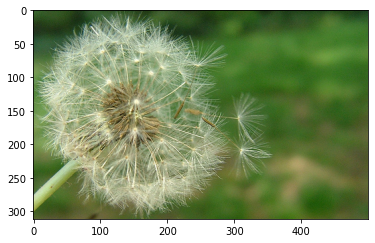

In [81]:
plt.imshow(new.reshape(312, 500, 3))